In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.applications import mobilenet_v2

from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import Sequential, optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.metrics import classification_report, confusion_matrix
import itertools

import random
import os

%matplotlib inline

In [17]:
# settings for reproducibility
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

is_use_gpu = True
if is_use_gpu:
    gpu_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
    os.environ['TF_USE_CUDNN'] = '1'
else:
    os.environ["CUDA_VISIBLE_DEVICES"] ="-1"

Define locations of the train and validation datasets:

<h3>Utility Functions</h3>

In [18]:
# Utility function for quick class name access
def get_class_name(generator, image_id):
    # Get the image class and map its index with the names of the classes
    image_label_id = np.argmax(generator[image_id][1][0])
    classes_list = list(generator.class_indices.keys())
    return classes_list

In [35]:
# Utility function for plotting of the model results
def visualize_results(history):
    # Plot the accuracy and loss curves
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlim([0, 100])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xlim([0, 100])
    plt.legend()

    plt.show()

In [20]:
# Utility function for obtaining of the errors 
def obtain_errors(val_generator, predictions):
    # Get the filenames from the generator
    fnames = validation_generator.filenames

    # Get the ground truth from generator
    ground_truth = validation_generator.classes

    # Get the dictionary of classes
    label2index = validation_generator.class_indices

    # Obtain the list of the classes
    idx2label = list(label2index.keys())
    print("The list of classes: ", idx2label)

    # Get the class index
    predicted_classes = np.argmax(predictions, axis=1)

    errors = np.where(predicted_classes != ground_truth)[0]
    print("Number of errors = {}/{}".format(len(errors),validation_generator.samples))
    
    return idx2label, errors, fnames

In [21]:
# Utility function for visualization of the errors
def show_errors(idx2label, errors, predictions, fnames):
    # Show the errors
    for i in range(len(errors)):
        pred_class = np.argmax(predictions[errors[i]])
        pred_label = idx2label[pred_class]

        title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
            fnames[errors[i]].split('/')[0],
            pred_label,
            predictions[errors[i]][pred_class])

        original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
        plt.figure(figsize=[7,7])
        plt.axis('off')
        plt.title(title)
        plt.imshow(original)
        plt.show()

In [22]:
# obtained from https://deeplizard.com/learn/video/km7pxKy4UHU

def plot_confusion_matrix(cm, classes,
                        normalize,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(3)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
def generate_spoofing_metrics(confusion_matrix_result):  
    TN, FP, FN, TP = confusion_matrix_result.ravel()
    APCER = FP / (TN + FP)
    BPCER = FN/(FN + TP)
    ACER = (APCER + BPCER) / 2
    print("APCER: "+str(APCER))
    print("BPCER: "+str(BPCER))
    print("ACER: "+str(ACER))

<h3>Experiment</h3>

Create the model setting ``include_top`` parameter to ``False`` in order to exclude the fully-connected layers at the top of the network.

In [24]:
# Init the VGG model 
mobile_netv2_conv = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in mobile_netv2_conv.layers[:-73]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in mobile_netv2_conv.layers:
    print(layer, layer.trainable)

# Create the model
model = Sequential()

# Add the vgg convolutional base model
model.add(mobile_netv2_conv)

# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

print(len(mobile_netv2_conv.layers))

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fab440a2760> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fab440a2fa0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fac7416c700> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fab44033400> False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7fab4403b760> False
<tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7fab44033e50> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fab44058b20> False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7fab440581c0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fab44060640> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fab187c7f40> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fab187d9580

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              64226304  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 66,487,363
Trainable params: 66,268,163
Non-trainable params: 219,200
_________________________________________________________________
155


<h3>2. Prepare the training and validation data</h3>

In [46]:
train_dir = './experimento2/dataset7030/train'
validation_dir = './experimento2/dataset7030/test'

image_size = 224

In [47]:
# Load the normalized images
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15, brightness_range=[0.2,1.0], zoom_range=[0.5,1.0])
validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 64
val_batchsize = 8

# Data generator for training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data generator for validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 4200 images belonging to 3 classes.
Found 1800 images belonging to 3 classes.


<h3>3. Visualizing the datasets</h3>

The shape of train images: (224, 224, 3)
The shape of validation images: (224, 224, 3)


Text(0.5, 1.0, "Validation class name: ['contactlens', 'live', 'printed']")

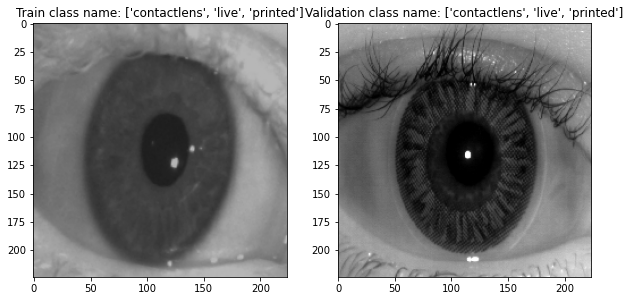

In [48]:
# Choose the image index for the visualization
image_id = 5

# Get the train image shape 
print("The shape of train images: {}".format(train_generator[image_id][0][0].shape))

# Get the validation image shape 
print("The shape of validation images: {}".format(validation_generator[image_id][0][0].shape))

# Visualize the train image example
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.imshow(train_generator[image_id][0][0])

# Show the train image class
plt.title("Train class name: {}".format(get_class_name(train_generator, image_id)))

# Visualize the validation image example
plt.subplot(122)
plt.imshow(validation_generator[image_id][0][0])

# show image class
plt.title("Validation class name: {}".format(get_class_name(validation_generator, image_id)))

<h3>4. Train the model</h3>

In [49]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
#cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,save_weights_only=False,verbose=1)

Epoch 1/100
66/65 [==============================] - 56s 852ms/step - loss: 0.0019 - acc: 0.9995 - val_loss: 1.5360e-04 - val_acc: 1.0000
Epoch 2/100
66/65 [==============================] - 56s 853ms/step - loss: 1.1129e-05 - acc: 1.0000 - val_loss: 8.9497e-06 - val_acc: 1.0000
Epoch 3/100
66/65 [==============================] - 56s 852ms/step - loss: 0.0020 - acc: 0.9993 - val_loss: 7.4716e-07 - val_acc: 1.0000
Epoch 4/100
66/65 [==============================] - 56s 855ms/step - loss: 0.0036 - acc: 0.9995 - val_loss: 7.2428e-06 - val_acc: 1.0000
Epoch 5/100
66/65 [==============================] - 57s 861ms/step - loss: 1.2758e-07 - acc: 1.0000 - val_loss: 1.3281e-05 - val_acc: 1.0000
Epoch 6/100
66/65 [==============================] - 56s 855ms/step - loss: 0.0015 - acc: 0.9995 - val_loss: 6.6983e-05 - val_acc: 1.0000
Epoch 7/100
66/65 [==============================] - 57s 863ms/step - loss: 2.9121e-04 - acc: 0.9998 - val_loss: 0.0036 - val_acc: 0.9983
Epoch 8/100
66/65 [=======

66/65 [==============================] - 57s 863ms/step - loss: 1.2831e-06 - acc: 1.0000 - val_loss: 8.6329e-07 - val_acc: 1.0000
Epoch 60/100
66/65 [==============================] - 57s 869ms/step - loss: 1.4924e-05 - acc: 1.0000 - val_loss: 4.7319e-06 - val_acc: 1.0000
Epoch 61/100
66/65 [==============================] - 57s 868ms/step - loss: 1.3377e-06 - acc: 1.0000 - val_loss: 1.5922e-06 - val_acc: 1.0000
Epoch 62/100
66/65 [==============================] - 58s 879ms/step - loss: 0.0012 - acc: 0.9998 - val_loss: 6.6950e-07 - val_acc: 1.0000
Epoch 63/100
66/65 [==============================] - 58s 884ms/step - loss: 1.0491e-05 - acc: 1.0000 - val_loss: 7.6763e-06 - val_acc: 1.0000
Epoch 64/100
66/65 [==============================] - 57s 870ms/step - loss: 1.6943e-04 - acc: 0.9998 - val_loss: 4.6588e-05 - val_acc: 1.0000
Epoch 65/100
66/65 [==============================] - 57s 859ms/step - loss: 0.0012 - acc: 0.9998 - val_loss: 5.8033e-04 - val_acc: 0.9994
Epoch 00065: early s

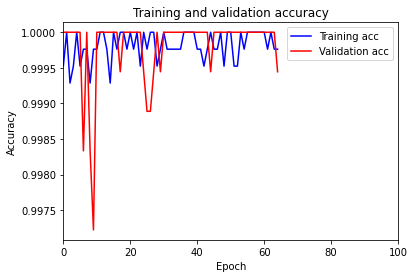

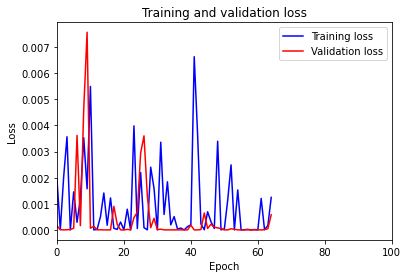

In [52]:
# Configure the model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=100,
      callbacks = [es_callback],
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

# Save the model
#model.save('4_unkwnown.h5')

# Run the function to illustrate accuracy and loss
visualize_results(history)

In [9]:
from tensorflow.keras.models import load_model
model = load_model('./experimento3/resultados/1_rmsprop_weights.h5')

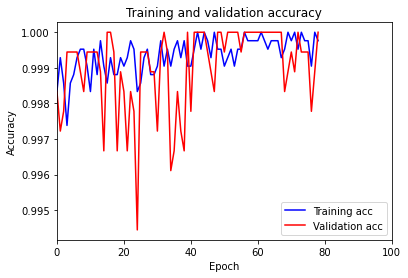

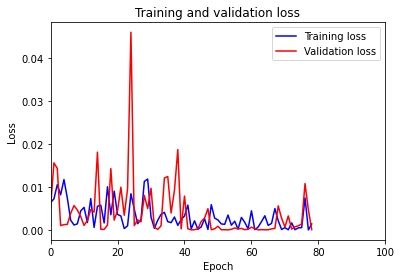

In [45]:
visualize_results(history)

In [14]:
# Get the predictions from the model using the generator
predictions = model.predict(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)

# Run the function to get the list of classes and errorattrs
idx2label, errors, fnames = obtain_errors(validation_generator, predictions)

# Run the function to illustrate the error cases
#show_errors(idx2label, errors, predictions, fnames)

263/262 [==============================] - 27s 103ms/step
The list of classes:  ['contactlens', 'live', 'printed']
Number of errors = 10/2100


Classification Report
              precision    recall  f1-score   support

 contactlens       1.00      1.00      1.00       525
        live       0.98      1.00      0.99       525
     printed       1.00      0.99      1.00      1050

    accuracy                           1.00      2100
   macro avg       0.99      1.00      0.99      2100
weighted avg       1.00      1.00      1.00      2100

Confusion matrix
[[ 524    1    0]
 [   1  524    0]
 [   1    7 1042]]


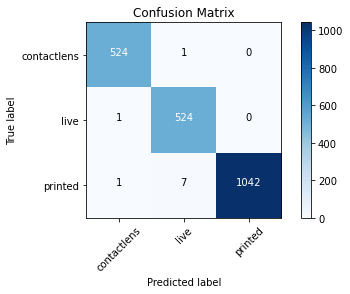

In [15]:
Y_pred = predictions
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(validation_generator.classes, y_pred)
print('Classification Report')
target_names = validation_generator.class_indices.keys()
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))



#plot_confusion_matrix(cm=cm, classes=target_names, normalize=False, title='Confusion Matrix')
plot_confusion_matrix(cm=cm, classes=target_names, normalize=False, title='Confusion Matrix')
#generate_spoofing_metrics(cm)

In [17]:
#Posiblemente sirva para 3 clases
#confusion_matrix_result = confusion_matrix(validation_generator.classes, y_pred)
#print(confusion_matrix_result)
#FP = cm.sum(axis=0) - np.diag(cm)  
#FN = cm.sum(axis=1) - np.diag(cm)
#TP = np.trace(cm)
#TN = cm.sum() - (FP + FN + TP)

#APCER = FP / (TN + FP)
#BPCER = FN/(FN + TP)
#ACER = (APCER + BPCER) / 2
#print("APCER: "+str(APCER))
#print("BPCER: "+str(BPCER))
#print("ACER: "+str(ACER))


#print(cm.sum(axis=0))

In [20]:
#save_dir  = './experimento3/resultados/1_rmsprop_weights.h5'
#model.save(save_dir)

In [38]:
import sys
import numpy
print(idx2label)
#np.set_printoptions(formatter = {'all':lambda x: '{}\n'.format(x)})
#np.set_printoptions(threshold=sys.maxsize)
#np.set_printoptions(formatter = {'all':lambda x: '{}\n'.format(x)})
print(predictions[:,1])

['contactlens', 'live', 'printed']
[6.157901402397937e-18
 9.606204042942809e-15
 1.1961856837578078e-23
 3.344272325061155e-29
 9.937452226766572e-22
 2.623354573729759e-24
 1.2247361870325324e-13
 5.179708398306282e-11
 1.5790452722802446e-17
 7.0637375948479075e-09
 1.3580761762665888e-21
 1.3581643267395818e-21
 1.0463254778258282e-22
 9.045961061104255e-26
 3.2980105079801146e-26
 0.00549284415319562
 1.1761033250558779e-26
 8.153086724480094e-22
 8.022988258569765e-20
 1.5477556983341913e-22
 3.5800054191742134e-14
 2.0425932278056904e-26
 4.9095332182997165e-30
 3.464816724110908e-24
 2.6665252720200823e-18
 3.4800093866314263e-17
 4.725526678403709e-14
 1.3114493331819105e-16
 1.7119650489884825e-18
 3.973874553801337e-15
 4.763016356649184e-14
 1.6210062805943615e-12
 1.3623579684918264e-27
 1.2190055631577934e-09
 7.694489644505427e-15
 4.5726912357303956e-18
 1.747371398414988e-16
 9.328556655026984e-18
 1.2308518787529366e-11
 2.1130272912975745e-18
 3.081422730459583e-18
 